# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import pandas as pd

# Loading data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
#Input coloured image and returned the gray image
def rgb_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

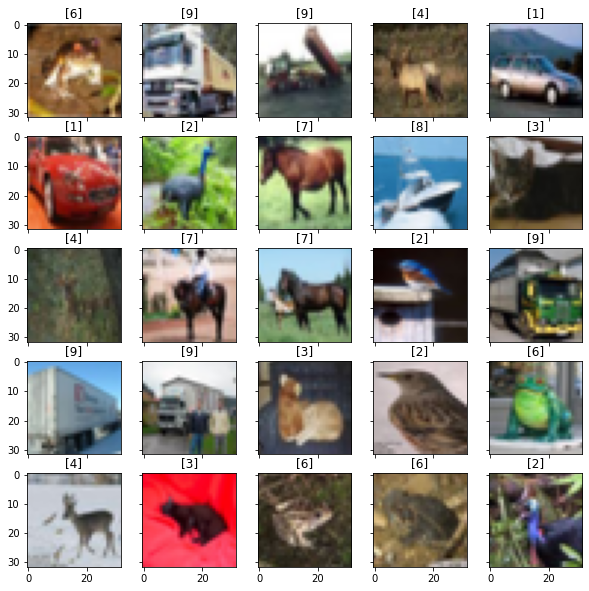

In [ ]:
#Display sample images from the dataset
fig, ax = plt.subplots(5,5,sharex=True,sharey=True,figsize=(10,10))
c=0
for i in range(0,5):
    for j in range (0,5):
        ax[i,j].imshow(x_train[c])
        ax[i,j].set_title(y_train[c])
        c=c+1

In [ ]:
#Our lists to store the converted images
x_train_Gray = []
x_test_Gray = []

#Iterate over number of images for training set
for i in range(x_train.shape[0]):
    img = x_train[i]
    #convert and append
    x_train_Gray.append(rgb_gray(img))
print(len(x_train_Gray))

#Same process for the test images
for i in range(x_test.shape[0]):
    img = x_test[i]
    x_test_Gray.append(rgb_gray(img))
print(len(x_test_Gray))

50000
10000


In [ ]:
#Convert the given list to a numpy array for input
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

#Reshape the given data into (m, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim,img_dim,1)
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

In [ ]:
#Dividing each pixel by 255 to get a normalized value
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255

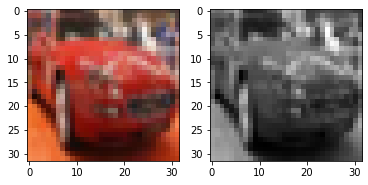

In [ ]:
im1 = x_train[5]
fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(im1)
im2 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
ax[1].imshow(im2, cmap='gray')

# Model

In [ ]:
#ENCODER MODEL
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(lat_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder_model')
# encoder.summary()

#DECODER MODEL
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding= 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding= 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding ='same')(x)
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)
decoder = Model(latent_inputs, outputs, name = 'decoder_model')
# decoder.summary()

In [ ]:
#AUTOENCODER MODEL
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 256)               1418496   
                                                                 
 decoder_model (Functional)  (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(loss = "mse", optimizer = 'Adam', metrics = ['accuracy'])
history = autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 25, batch_size = 32)
x_decoded = autoencoder.predict(x_test_Gray)

Epoch 1/25
1563/1563 [==============================] - 76s 12ms/step - loss: 0.0152 - accuracy: 0.4870 - val_loss: 0.0109 - val_accuracy: 0.5077
Epoch 2/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0098 - accuracy: 0.5057 - val_loss: 0.0091 - val_accuracy: 0.4980
Epoch 3/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0088 - accuracy: 0.5135 - val_loss: 0.0086 - val_accuracy: 0.5120
Epoch 4/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0083 - accuracy: 0.5198 - val_loss: 0.0081 - val_accuracy: 0.5285
Epoch 5/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0080 - accuracy: 0.5241 - val_loss: 0.0078 - val_accuracy: 0.5344
Epoch 6/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0077 - accuracy: 0.5281 - val_loss: 0.0079 - val_accuracy: 0.5231
Epoch 7/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0074 - accuracy: 0.5334 - val_loss: 0.0076 -

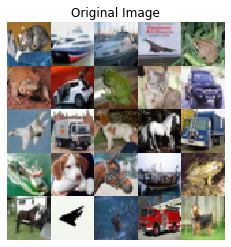

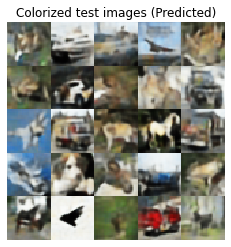

In [ ]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()
